# Imports

In [139]:
import researchpy
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="darkgrid")

# Datasets

In [2]:
df = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa.csv', sep=',')
df2 = pd.read_csv(r'C:\Users\brcalazans\Desktop\Pessoal\FIAP\Aulas\Fase 2\Tech Challenge\dados\Dados Históricos - Ibovespa (4).csv', sep=',')

In [3]:
df = pd.concat([df, df2], ignore_index=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5600 non-null   object 
 1   Último    5600 non-null   float64
 2   Abertura  5600 non-null   float64
 3   Máxima    5600 non-null   float64
 4   Mínima    5600 non-null   float64
 5   Vol.      5599 non-null   object 
 6   Var%      5600 non-null   object 
dtypes: float64(4), object(3)
memory usage: 306.4+ KB


In [5]:
df.shape

(5600, 7)

# Tratamento dos Dados

## Tratando valores Nulos

In [6]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [7]:
df.loc[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1258,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


Para esse cenário, como temos apenas uma única linha, removeremos essa linha inteira para continuarmos nossa análise

In [8]:
df = df.dropna()
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

## Modificando os Tipos dos Dados

In [9]:
# Convertendo variável 'Data' de object para Datetime
df['Data'] = df['Data'].str.replace('.', '-')
df['Data'] = pd.to_datetime(df['Data'], format="%d-%m-%Y")

In [10]:
df['Var%'] = df['Var%'].str.replace("%", "")
df['Var%'] = df['Var%'].str.replace(",", ".")
df['Var%'] = df['Var%'].astype(float)

In [11]:
df['Vol.'] = df['Vol.'].str.replace(',', '.')

In [12]:
for _, row in df.iterrows():
    value = row['Vol.']
    try:
        if value[-1] == 'M':
            value = value.replace('M', '')
            value = float(value) * 1_000_000
        elif value[-1] == 'K':
            value = value.replace('K', '')
            value = float(value) * 1_000_00
        else:
            print('ERRO :', value)
            break
    except TypeError:
        print(value)
    df.loc[df.index == _, 'Vol.'] = value

In [13]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2021-03-11,114.984,112.782,115.127,112.776,12090000.0,1.96
1,2021-03-10,112.776,111.331,112.928,109.999,12510000.0,1.30
2,2021-03-09,111.331,110.611,112.525,109.343,12140000.0,0.65
3,2021-03-08,110.612,115.202,115.202,110.268,13700000.0,-3.98
4,2021-03-05,115.202,112.690,115.504,112.504,13250000.0,2.23


In [14]:
df['Vol.'] = round(df['Vol.'].astype(float))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5599 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      5599 non-null   datetime64[ns]
 1   Último    5599 non-null   float64       
 2   Abertura  5599 non-null   float64       
 3   Máxima    5599 non-null   float64       
 4   Mínima    5599 non-null   float64       
 5   Vol.      5599 non-null   float64       
 6   Var%      5599 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 349.9 KB


In [16]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2021-03-11,114.984,112.782,115.127,112.776,12090000.0,1.96
1,2021-03-10,112.776,111.331,112.928,109.999,12510000.0,1.30
2,2021-03-09,111.331,110.611,112.525,109.343,12140000.0,0.65
3,2021-03-08,110.612,115.202,115.202,110.268,13700000.0,-3.98
4,2021-03-05,115.202,112.690,115.504,112.504,13250000.0,2.23


## Criando novas Colunas com base nas Datas

In [54]:
df['Ano'] = df['Data'].dt.year
df['Mês'] = df['Data'].dt.month
df['Dia'] = df['Data'].dt.day

In [55]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Faixa Total,Faixa Abertura,Faixa Máxima,Faixa Mínima,Faixa Vol.,Faixa Var%,Ano,Mês,Dia
0,2021-03-11,114.984,112.782,115.127,112.776,12090000.0,1.96,4.0,4.0,4.0,4.0,3.0,4.0,2021,3,11
1,2021-03-10,112.776,111.331,112.928,109.999,12510000.0,1.30,4.0,4.0,4.0,4.0,3.0,4.0,2021,3,10
2,2021-03-09,111.331,110.611,112.525,109.343,12140000.0,0.65,4.0,4.0,4.0,4.0,3.0,3.0,2021,3,9
3,2021-03-08,110.612,115.202,115.202,110.268,13700000.0,-3.98,4.0,4.0,4.0,4.0,3.0,1.0,2021,3,8
4,2021-03-05,115.202,112.690,115.504,112.504,13250000.0,2.23,4.0,4.0,4.0,4.0,3.0,4.0,2021,3,5


# Análise Exploratória de Dados

In [17]:
df.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5599,5599.000000,5599.000000,5599.000000,5599.000000,5.599000e+03,5599.000000
mean,2012-04-17 13:40:56.795856384,58.759518,58.741966,59.342335,58.146607,6.787754e+07,0.052700
min,2000-12-27 00:00:00,8.371000,8.397000,8.513000,8.225000,1.000000e+06,-14.780000
25%,2006-08-15 12:00:00,37.389500,37.374500,37.886000,36.819000,3.080000e+06,-0.880000
50%,2012-04-16 00:00:00,56.384000,56.385000,56.943000,55.805000,5.640000e+06,0.080000
75%,2017-12-12 12:00:00,74.301000,74.226000,74.980000,73.142000,9.973800e+07,1.035000
max,2023-08-07 00:00:00,130.776000,130.776000,131.190000,129.526000,9.949600e+08,14.660000
std,NaN,30.996112,30.990471,31.239041,30.737363,1.170010e+08,1.748127


## Análisando a Variável Target

Conforme a análise acima, percebemos que a média da nossa variável Target é de 58,74 e o Desvio Padrão é de aproximadamente 31. Isso significa que a maioria dos valores estão mais concentrados em torno da média.

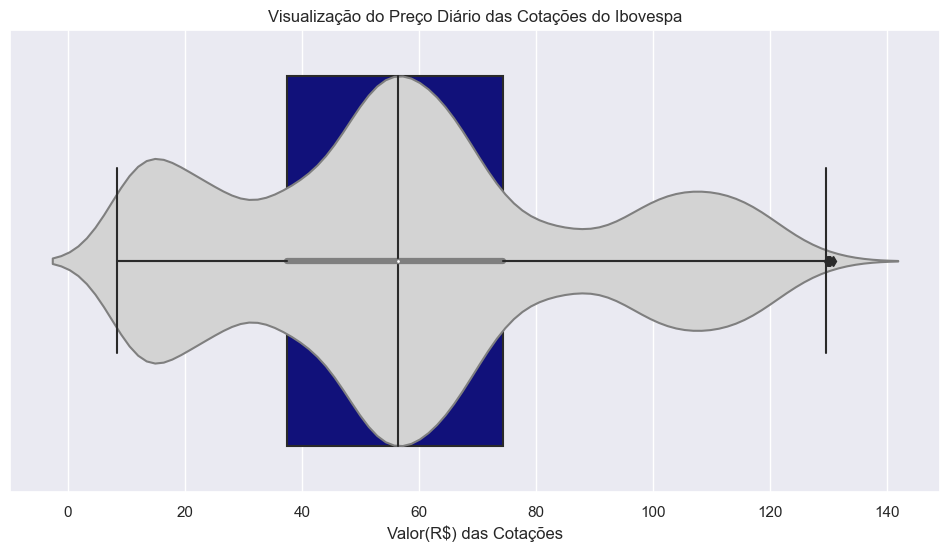

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
sns.violinplot(x='Último', data=df, ax=ax, color='lightgray')
sns.boxplot(x='Último', data=df, ax=ax, whis=1.5, color='darkblue')
ax.set_xlabel("Valor(R$) das Cotações")
ax.set_title('Visualização do Preço Diário das Cotações do Ibovespa')
plt.show()

Conforme analisamos acima, reparem que o Boxplot e o ViolinPlot nos mostram com mais clareza essa mais concentração dos Dados perto da média que é 58.74.

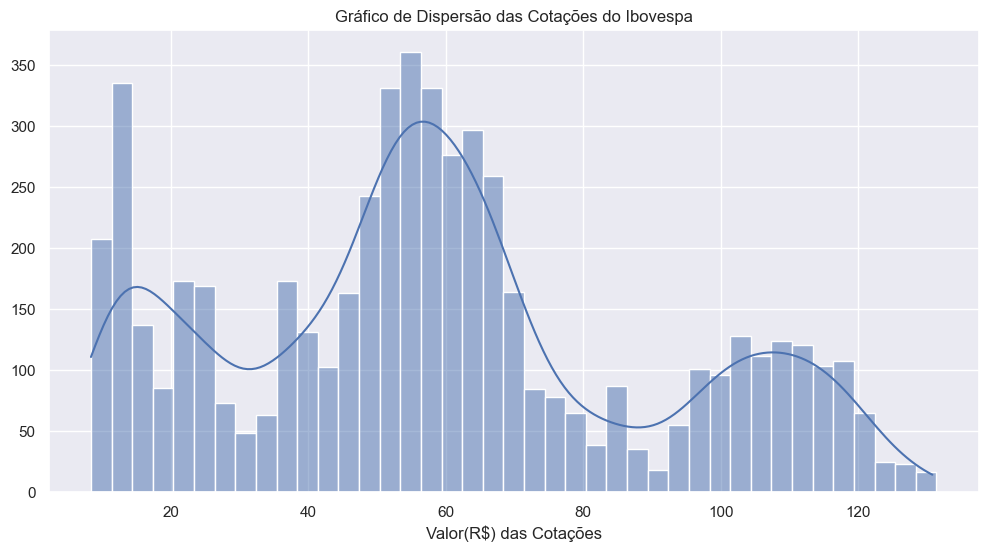

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=df, x="Último", binwidth=3,kde=True)
ax.set_title("Gráfico de Dispersão das Cotações do Ibovespa")
ax.set_ylabel("")
ax.set_xlabel("Valor(R$) das Cotações")
plt.show()

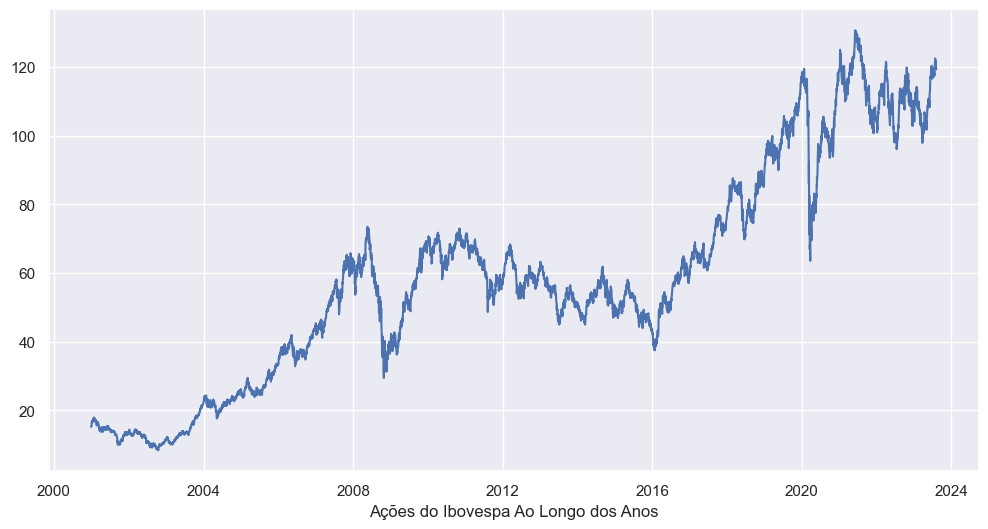

In [59]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=df, x='Data', y="Último")
ax.set_ylabel("")
ax.set_xlabel("Ações do Ibovespa Ao Longo dos Anos")
plt.show()

## Analisando as Variáveis Qualitativas

C:\Users\brcalazans\AppData\Local\Temp\ipykernel_20312\2977271866.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.barplot(data=df, x='Ano', y='Último', color='steelblue', ci=None)
C:\Users\brcalazans\AppData\Local\Temp\ipykernel_20312\2977271866.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.barplot(data=df, x='Mês', y='Último', color='steelblue', ci=None)
C:\Users\brcalazans\AppData\Local\Temp\ipykernel_20312\2977271866.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  fig = sns.barplot(data=df, x='Dia', y='Último', color='steelblue', ci=None)


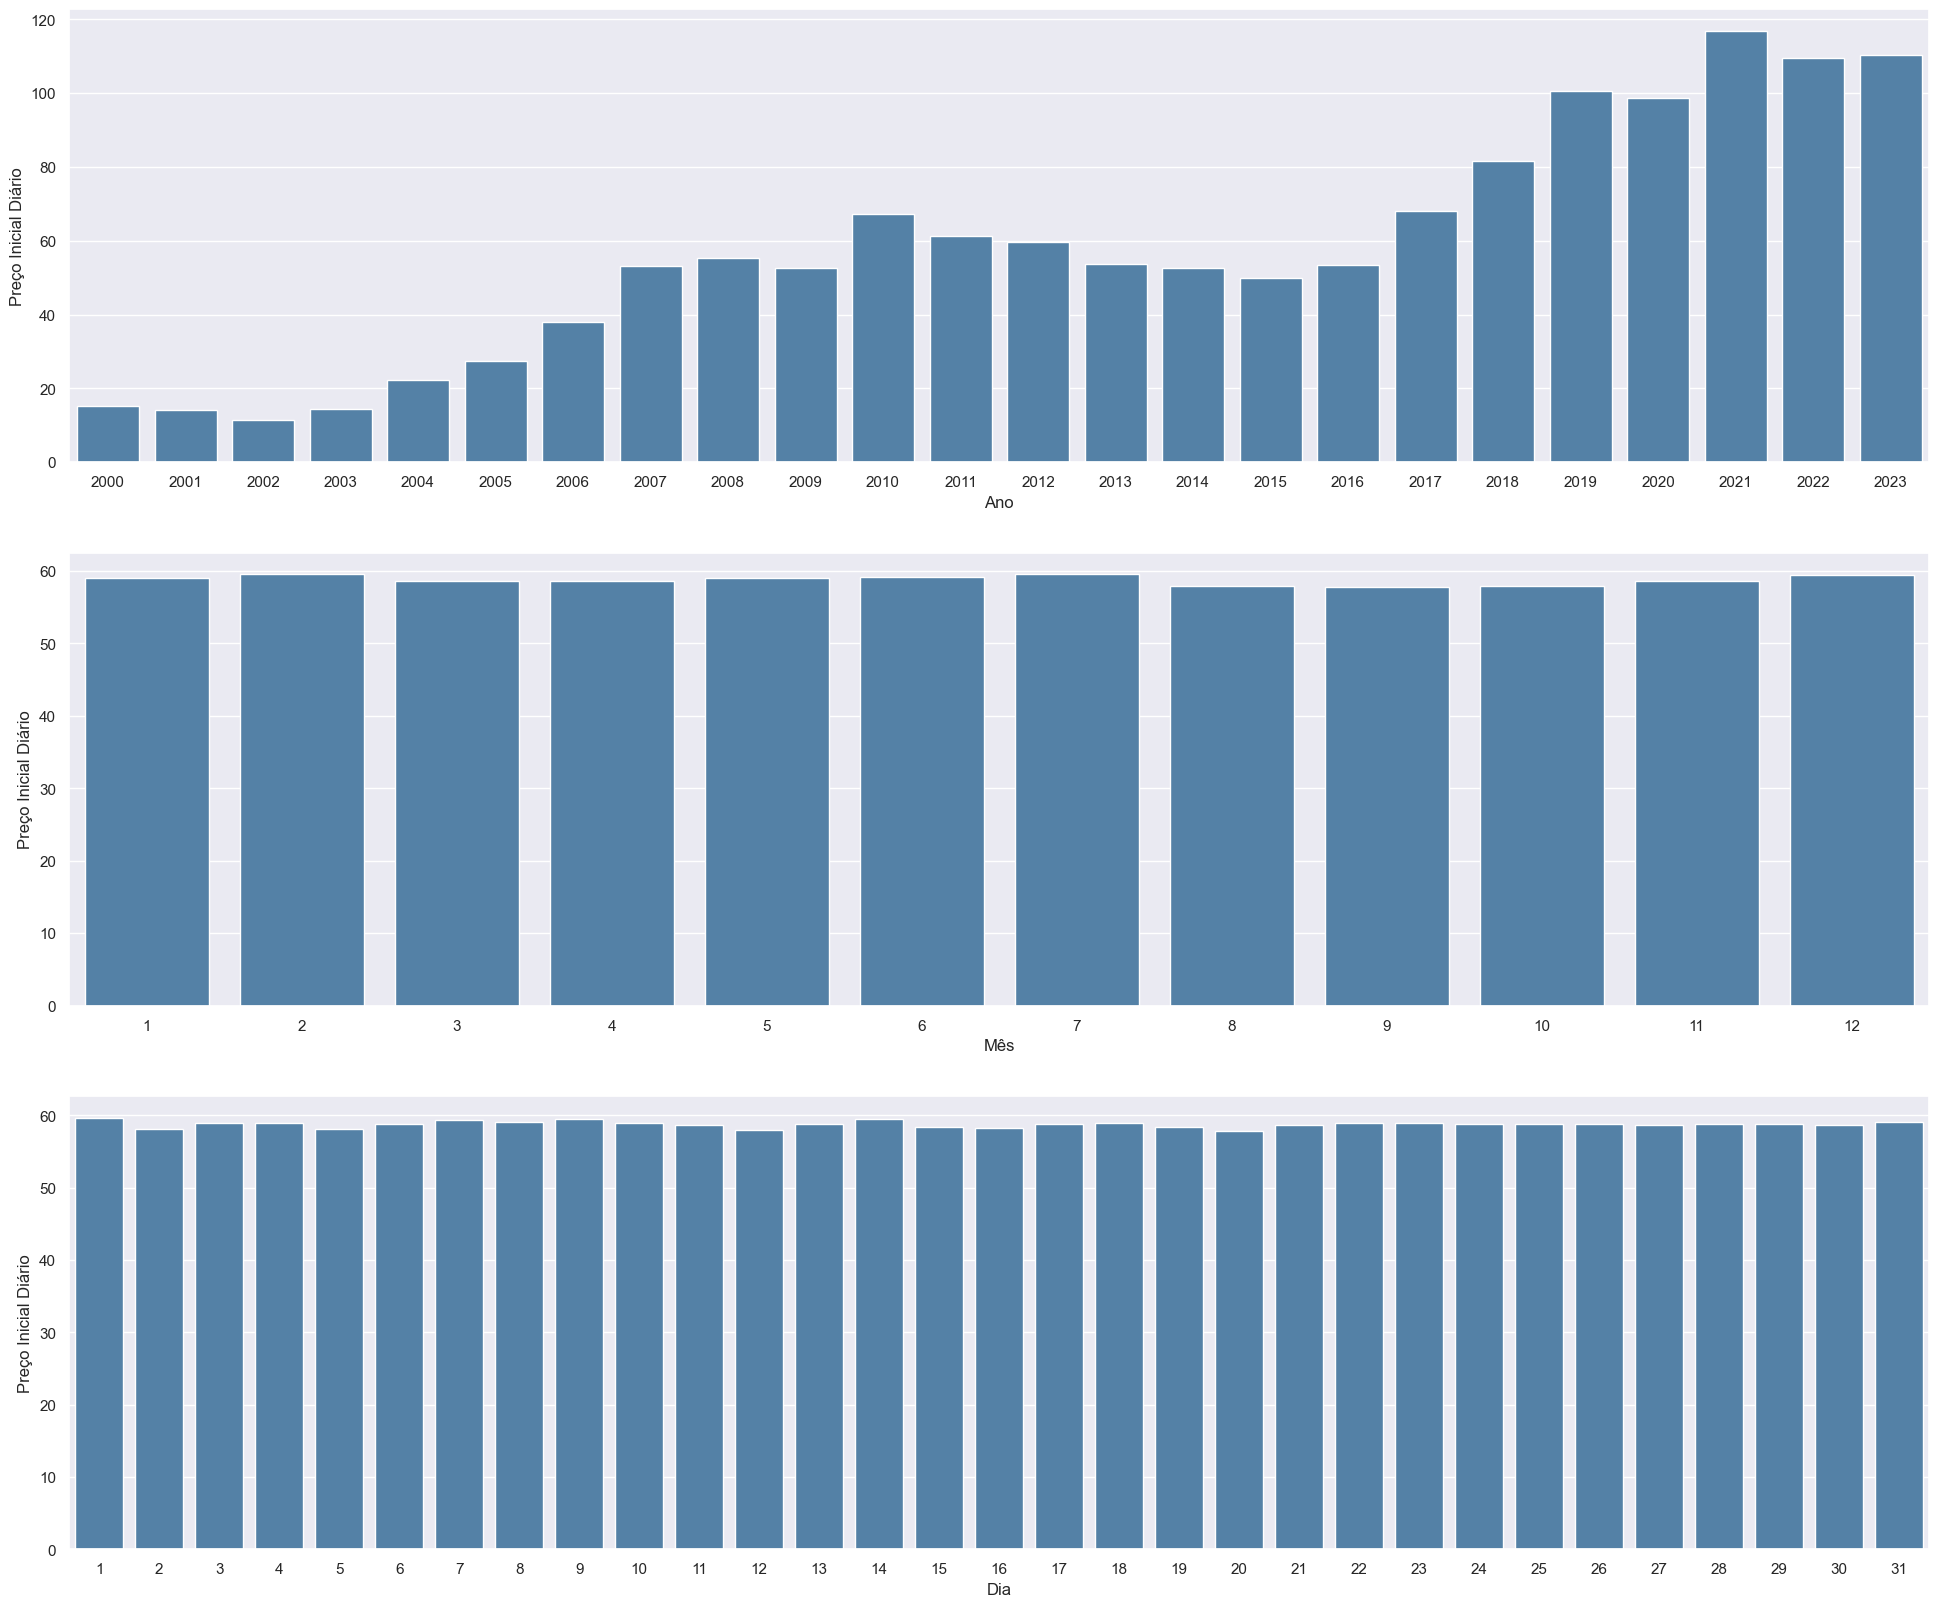

In [81]:
plt.figure(figsize=(24,20))

plt.subplot(3,1,1)
fig = sns.barplot(data=df, x='Ano', y='Último', color='steelblue', ci=None)
fig.set_title("")
fig.set_ylabel('Preço Inicial Diário')


plt.subplot(3,1,2)
fig = sns.barplot(data=df, x='Mês', y='Último', color='steelblue', ci=None)
fig.set_title("")
fig.set_ylabel('Preço Inicial Diário')


plt.subplot(3,1,3)
fig = sns.barplot(data=df, x='Dia', y='Último', color='steelblue', ci=None)
fig.set_title("")
fig.set_ylabel('Preço Inicial Diário')

plt.show()


## Analisando as Variáveis Quantitativas

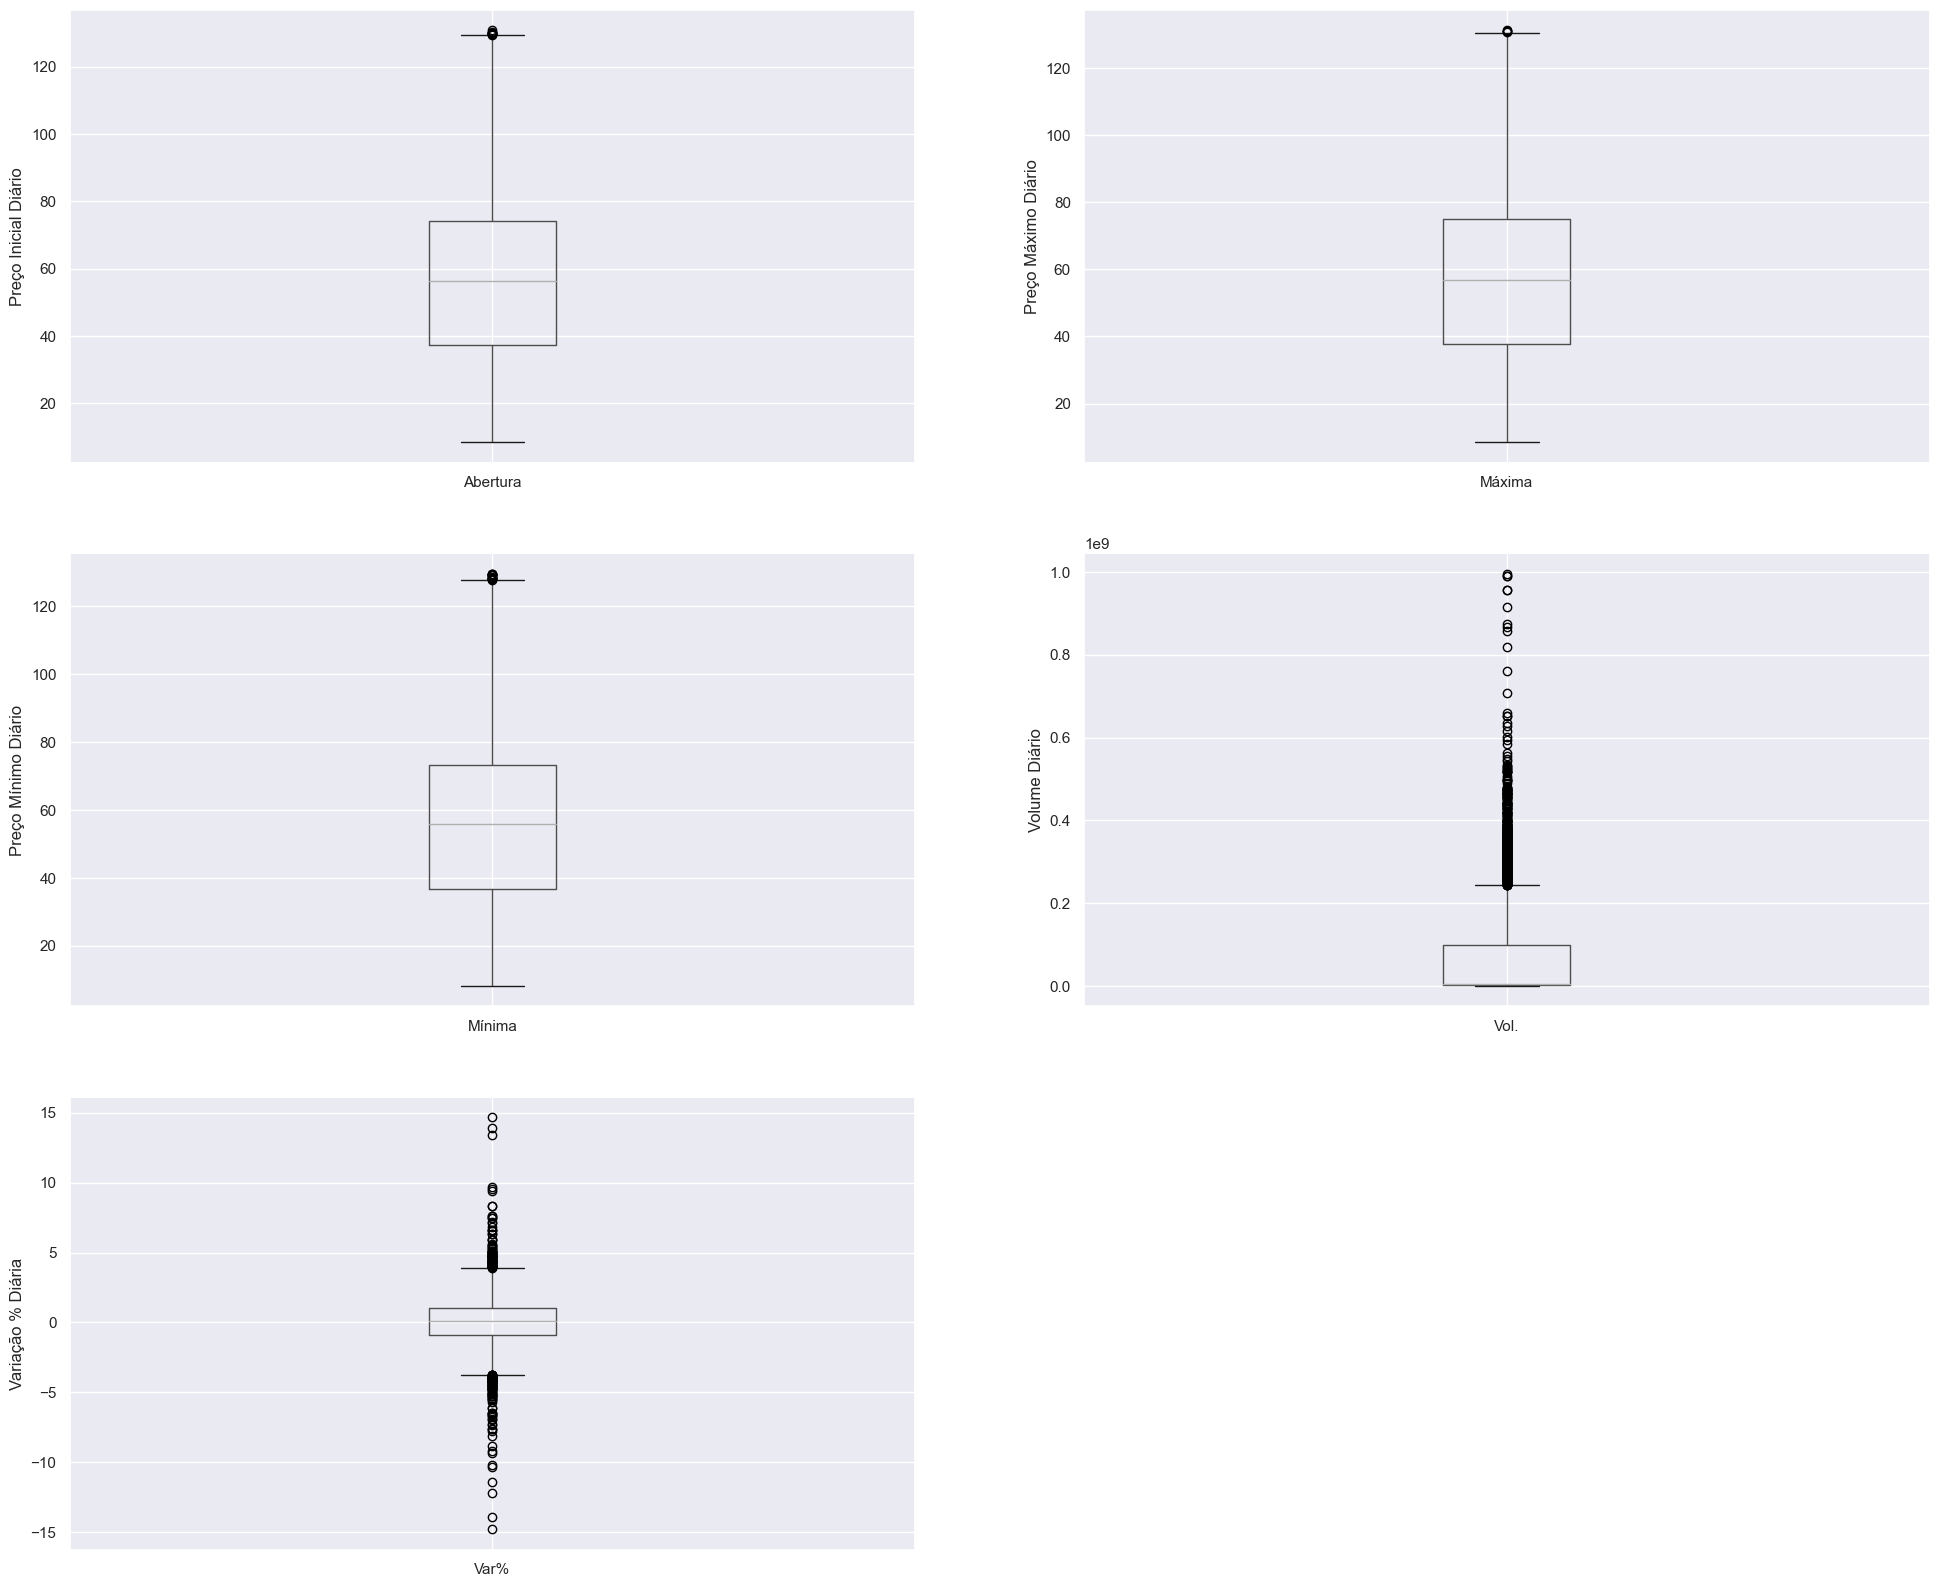

In [57]:
plt.figure(figsize=(24,20))

plt.subplot(3, 2, 1)
fig = df.boxplot(column='Abertura')
fig.set_title("")
fig.set_ylabel("Preço Inicial Diário")

plt.subplot(3, 2, 2)
fig = df.boxplot(column='Máxima')
fig.set_title("")
fig.set_ylabel("Preço Máximo Diário")

plt.subplot(3, 2, 3)
fig = df.boxplot(column='Mínima')
fig.set_title("")
fig.set_ylabel("Preço Mínimo Diário")

plt.subplot(3, 2, 4)
fig = df.boxplot(column='Vol.')
fig.set_title("")
fig.set_ylabel("Volume Diário")

plt.subplot(3, 2, 5)
fig = df.boxplot(column='Var%')
fig.set_title("")
fig.set_ylabel("Variação % Diária")

plt.show()

Percebemos que as Variáveis Abertura, Máxima e Mínima tem um formato bem parecido e as Variáveis de Volume e Variação tem muitos Outliers. Veremos em mais detalhes logo em seguida.

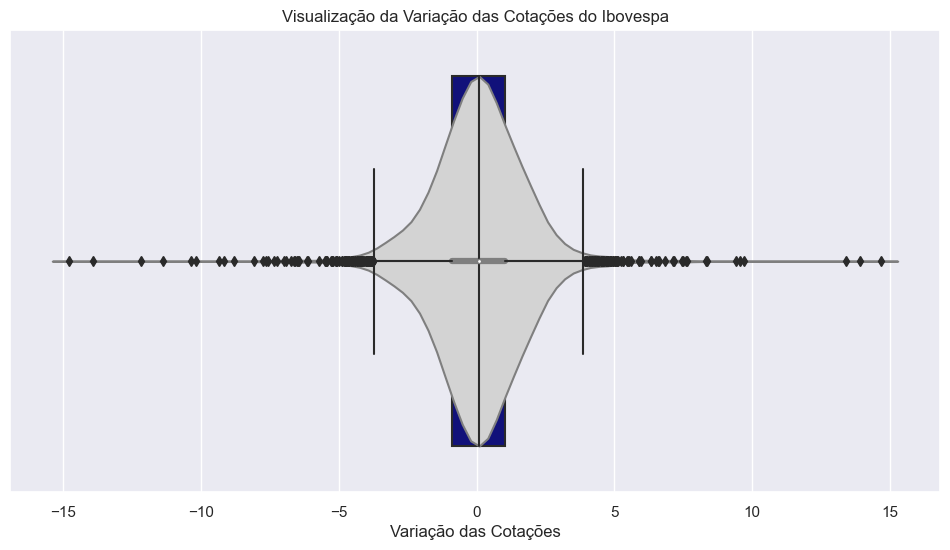

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
sns.violinplot(x='Var%', data=df, ax=ax, color='lightgray')
sns.boxplot(x='Var%', data=df, ax=ax, whis=1.5, color='darkblue')
ax.set_xlabel("Variação das Cotações")
ax.set_title('Visualização da Variação das Cotações do Ibovespa')
plt.show()

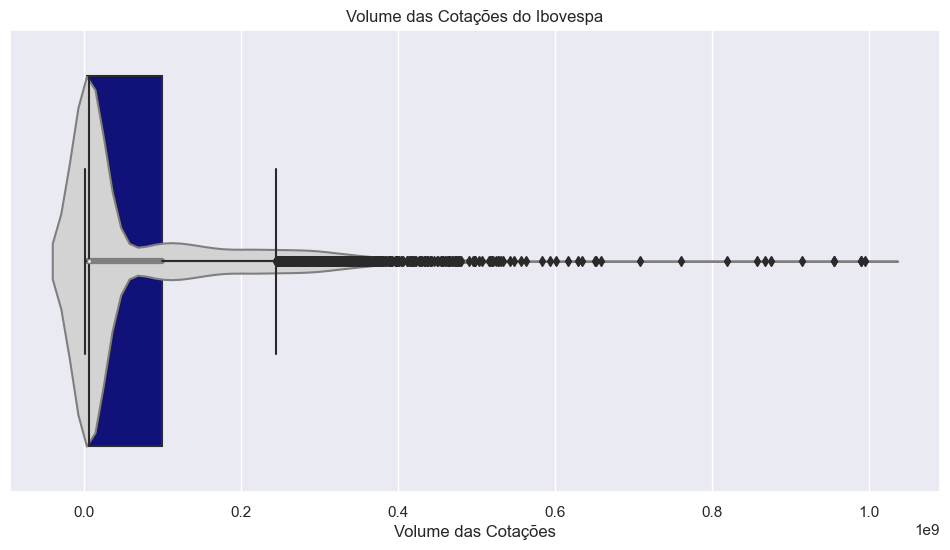

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
sns.violinplot(x='Vol.', data=df, ax=ax, color='lightgray')
sns.boxplot(x='Vol.', data=df, ax=ax, whis=1.5, color='darkblue')
ax.set_xlabel("Volume das Cotações")
ax.set_title('Volume das Cotações do Ibovespa')
plt.show()

Como percebemos acima, vemos que ambas as variáveis Variação e Volume tem uma oscilação muito grande e encontramos diversos Outliers nelas. Veremos ao decorrer da Análise a importância de cada variável e o quanto elas impactam na nossa variável Target.

## Analisando a Correlação da Variável Target com os Atributos

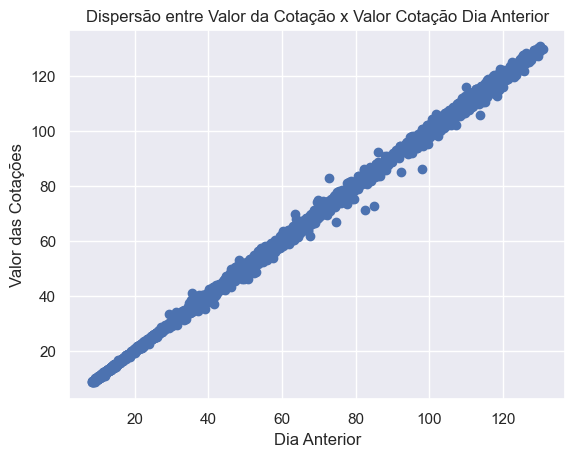

In [24]:
plt.scatter('Abertura', 'Último', data=df)
plt.xlabel("Dia Anterior")
plt.ylabel("Valor das Cotações")
plt.title("Dispersão entre Valor da Cotação x Valor Cotação Dia Anterior");

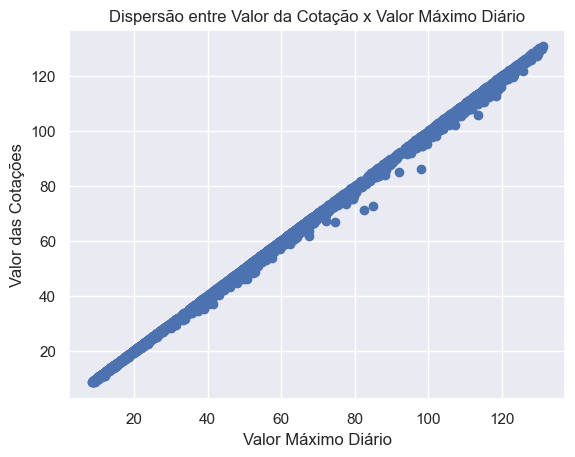

In [25]:
plt.scatter('Máxima', 'Último', data=df)
plt.xlabel("Valor Máximo Diário")
plt.ylabel("Valor das Cotações")
plt.title("Dispersão entre Valor da Cotação x Valor Máximo Diário");

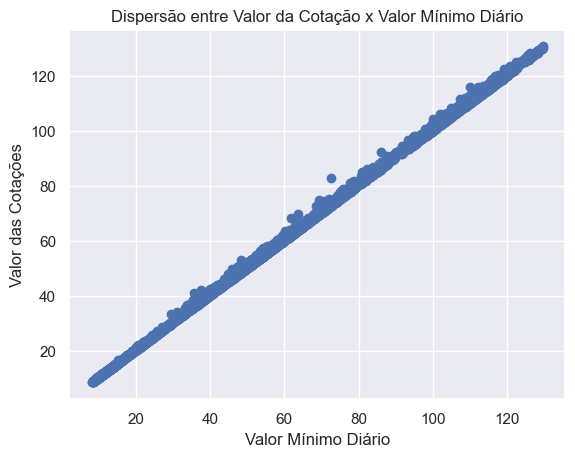

In [26]:
plt.scatter('Mínima', 'Último', data=df)
plt.xlabel("Valor Mínimo Diário")
plt.ylabel("Valor das Cotações")
plt.title("Dispersão entre Valor da Cotação x Valor Mínimo Diário");

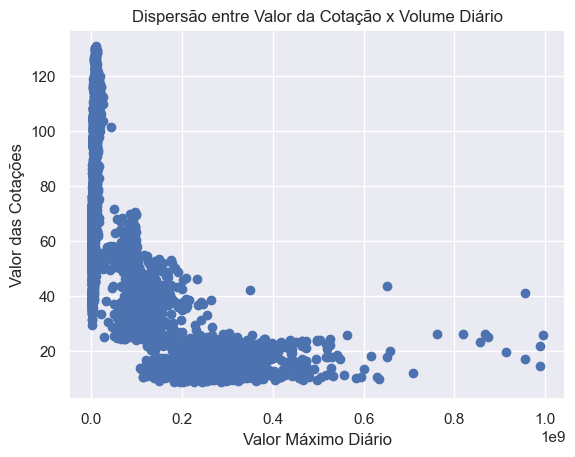

In [27]:
plt.scatter('Vol.', 'Último', data=df)
plt.xlabel("Valor Máximo Diário")
plt.ylabel("Valor das Cotações")
plt.title("Dispersão entre Valor da Cotação x Volume Diário");

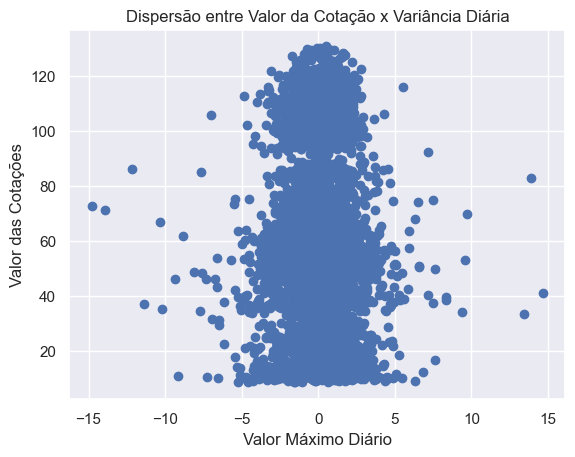

In [28]:
plt.scatter('Var%', 'Último', data=df)
plt.xlabel("Valor Máximo Diário")
plt.ylabel("Valor das Cotações")
plt.title("Dispersão entre Valor da Cotação x Variância Diária");

## Testes Estatísticos

Com base nas análises acima veremos as seguintes questões:
- Será que a Última Cotação(Target Último) é afetada pelo valor inicial? Pelo Valor Máximo e pelo Valor Mínimo?
- Será que a Última Cotação(Target Último) é afetada pelo Volume?
- Será que a Última Cotação(Target Último) é afetada pela Variância

Para responder as hipóteses levantadas, utilizaremos o teste Qui-Quadrado para avaliar as associações entre as variáveis em uma tabela de contingência.

In [29]:
Q1 = np.percentile(df['Último'], 25)
Q2 = np.percentile(df['Último'], 50)
Q3 = np.percentile(df['Último'], 75)
maximo = max(df['Último'])

print(Q1, Q2, Q3, maximo)

37.3895 56.384 74.301 130.776


In [30]:
df.loc[(df.Último >= 0) & (df.Último <=Q1), 'Faixa Total'] = 1.0
df.loc[(df.Último > Q1) & (df.Último <=Q2), 'Faixa Total'] = 2.0
df.loc[(df.Último > Q2) & (df.Último <=Q3), 'Faixa Total'] = 3.0
df.loc[(df.Último > Q3) & (df.Último <= maximo), 'Faixa Total'] = 4.0

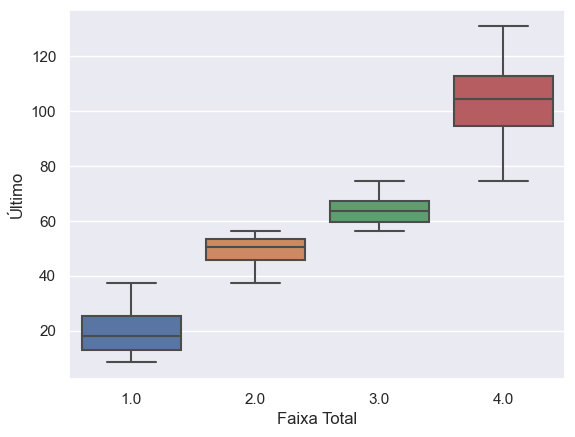

In [31]:
sns.boxplot(x='Faixa Total', y='Último', data=df)
plt.show()

In [95]:
tabela_valor_ano = pd.crosstab(df['Faixa Total'], df['Ano'], margins=True)
tabela_valor_mes = pd.crosstab(df['Faixa Total'], df['Mês'], margins=True)
tabela_valor_dia = pd.crosstab(df['Faixa Total'], df['Dia'], margins=True)

####   Teste de hipótese:
    H0: não há relação entre valor e ruído
    H1: há relação entre valor e ruído
    α = 0,05 (5%)

In [111]:
stat, p, dof, expected = chi2_contingency(tabela_valor_ano)
p

0.0

In [112]:
print('Graus de liberdade: dof=%d' % dof)

print('\n Tabela Esperada:')
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)

print('\n probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('\n Dependent (reject H0)')
else:
	print('\n Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('\n significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('\n Dependent (reject H0)')
else:
	print('\n Independent (fail to reject H0)')

Graus de liberdade: dof=96

 Tabela Esperada:
[[5.00089302e-01 6.15109841e+01 6.22611181e+01 6.25111627e+01
  6.22611181e+01 6.22611181e+01 6.15109841e+01 6.15109841e+01
  6.22611181e+01 6.15109841e+01 6.17610288e+01 6.22611181e+01
  6.15109841e+01 6.20110734e+01 6.20110734e+01 6.15109841e+01
  6.20110734e+01 6.15109841e+01 6.12609395e+01 6.20110734e+01
  6.22611181e+01 6.17610288e+01 6.25111627e+01 3.75066976e+01
  1.40000000e+03]
 [5.00089302e-01 6.15109841e+01 6.22611181e+01 6.25111627e+01
  6.22611181e+01 6.22611181e+01 6.15109841e+01 6.15109841e+01
  6.22611181e+01 6.15109841e+01 6.17610288e+01 6.22611181e+01
  6.15109841e+01 6.20110734e+01 6.20110734e+01 6.15109841e+01
  6.20110734e+01 6.15109841e+01 6.12609395e+01 6.20110734e+01
  6.22611181e+01 6.17610288e+01 6.25111627e+01 3.75066976e+01
  1.40000000e+03]
 [4.99732095e-01 6.14670477e+01 6.22166458e+01 6.24665119e+01
  6.22166458e+01 6.22166458e+01 6.14670477e+01 6.14670477e+01
  6.22166458e+01 6.14670477e+01 6.17169137e+01 6.2

In [114]:
stat, p, dof, expected = chi2_contingency(tabela_valor_mes)
p

0.637179521008996

In [115]:
print('Graus de liberdade: dof=%d' % dof)

print('\n Tabela Esperada:')
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)

print('\n probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('\n Dependent (reject H0)')
else:
	print('\n Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('\n significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('\n Dependent (reject H0)')
else:
	print('\n Independent (fail to reject H0)')

Graus de liberdade: dof=48

 Tabela Esperada:
[[ 119.77138775  106.51902125  123.77210216  114.77049473  122.02178961
   118.77120914  123.27201286  123.27201286  113.77031613  117.77103054
   107.26915521  109.01946776 1400.        ]
 [ 119.77138775  106.51902125  123.77210216  114.77049473  122.02178961
   118.77120914  123.27201286  123.27201286  113.77031613  117.77103054
   107.26915521  109.01946776 1400.        ]
 [ 119.68583676  106.44293624  123.68369352  114.68851581  121.93463118
   118.68637257  123.18396142  123.18396142  113.68905162  117.68690838
   107.19253438  108.94159671 1399.        ]
 [ 119.77138775  106.51902125  123.77210216  114.77049473  122.02178961
   118.77120914  123.27201286  123.27201286  113.77031613  117.77103054
   107.26915521  109.01946776 1400.        ]
 [ 479.          426.          495.          459.          488.
   475.          493.          493.          455.          471.
   429.          436.         5599.        ]]

 probability=0.950, cri

In [116]:
stat, p, dof, expected = chi2_contingency(tabela_valor_dia)
p

1.0

In [117]:
print('Graus de liberdade: dof=%d' % dof)

print('\n Tabela Esperada:')
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)

print('\n probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('\n Dependent (reject H0)')
else:
	print('\n Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('\n significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('\n Dependent (reject H0)')
else:
	print('\n Independent (fail to reject H0)')

Graus de liberdade: dof=124

 Tabela Esperada:
[[  40.25718878   44.2579032    47.25843901   47.25843901   48.00857296
    48.00857296   43.50776924   47.25843901   44.2579032    47.25843901
    47.25843901   43.50776924   48.00857296   47.75852831   43.00767994
    47.50848366   48.00857296   47.75852831   47.50848366   45.00803715
    43.7578139    47.75852831   47.75852831   43.50776924   40.00714413
    47.75852831   48.00857296   48.00857296   43.7578139    42.75763529
    24.25433113 1400.        ]
 [  40.25718878   44.2579032    47.25843901   47.25843901   48.00857296
    48.00857296   43.50776924   47.25843901   44.2579032    47.25843901
    47.25843901   43.50776924   48.00857296   47.75852831   43.00767994
    47.50848366   48.00857296   47.75852831   47.50848366   45.00803715
    43.7578139    47.75852831   47.75852831   43.50776924   40.00714413
    47.75852831   48.00857296   48.00857296   43.7578139    42.75763529
    24.25433113 1400.        ]
 [  40.22843365   44.226290

In [99]:
# Criando Faixa de Preços de Abertura das Cotações Diarias
Q1 = np.percentile(df['Abertura'], 25)
Q2 = np.percentile(df['Abertura'], 50)
Q3 = np.percentile(df['Abertura'], 75)
maximo = max(df['Abertura'])
print(Q1, Q2, Q3, maximo)

df.loc[(df.Abertura >= 0) & (df.Abertura <=Q1), 'Faixa Abertura'] = 1.0
df.loc[(df.Abertura > Q1) & (df.Abertura <=Q2), 'Faixa Abertura'] = 2.0
df.loc[(df.Abertura > Q2) & (df.Abertura <=Q3), 'Faixa Abertura'] = 3.0
df.loc[(df.Abertura > Q3) & (df.Abertura <= maximo), 'Faixa Abertura'] = 4.0

37.3745 56.385 74.226 130.776


In [100]:
# Criando Faixa de Preço Máximo das Cotações Diarias
Q1 = np.percentile(df['Máxima'], 25)
Q2 = np.percentile(df['Máxima'], 50)
Q3 = np.percentile(df['Máxima'], 75)
maximo = max(df['Máxima'])
print(Q1, Q2, Q3, maximo)

df.loc[(df.Máxima >= 0) & (df.Máxima <=Q1), 'Faixa Máxima'] = 1.0
df.loc[(df.Máxima > Q1) & (df.Máxima <=Q2), 'Faixa Máxima'] = 2.0
df.loc[(df.Máxima > Q2) & (df.Máxima <=Q3), 'Faixa Máxima'] = 3.0
df.loc[(df.Máxima > Q3) & (df.Máxima <= maximo), 'Faixa Máxima'] = 4.0

37.885999999999996 56.943 74.98 131.19


In [101]:
# Criando Faixa de Preço Mínimo das Cotações Diarias
Q1 = np.percentile(df['Mínima'], 25)
Q2 = np.percentile(df['Mínima'], 50)
Q3 = np.percentile(df['Mínima'], 75)
maximo = max(df['Mínima'])
print(Q1, Q2, Q3, maximo)

df.loc[(df.Mínima >= 0) & (df.Mínima <=Q1), 'Faixa Mínima'] = 1.0
df.loc[(df.Mínima > Q1) & (df.Mínima <=Q2), 'Faixa Mínima'] = 2.0
df.loc[(df.Mínima > Q2) & (df.Mínima <=Q3), 'Faixa Mínima'] = 3.0
df.loc[(df.Mínima > Q3) & (df.Mínima <= maximo), 'Faixa Mínima'] = 4.0

36.819 55.805 73.142 129.526


In [102]:
# Criando Faixa de Volume das Cotações Diarias
Q1 = np.percentile(df['Vol.'], 25)
Q2 = np.percentile(df['Vol.'], 50)
Q3 = np.percentile(df['Vol.'], 75)
maximo = max(df['Vol.'])
print(Q1, Q2, Q3, maximo)

df.loc[(df['Vol.'] >= 0)  & (df['Vol.'] <=Q1), 'Faixa Vol.'] = 1.0
df.loc[(df['Vol.'] > Q1) & (df['Vol.'] <=Q2), 'Faixa Vol.'] = 2.0
df.loc[(df['Vol.'] > Q2) & (df['Vol.'] <=Q3), 'Faixa Vol.'] = 3.0
df.loc[(df['Vol.'] > Q3) & (df['Vol.'] <= maximo), 'Faixa Vol.'] = 4.0

3080000.0 5640000.0 99738000.0 994960000.0


In [103]:
# Criando Faixa de Variação das Cotações Diarias
Q1 = np.percentile(df['Var%'], 25)
Q2 = np.percentile(df['Var%'], 50)
Q3 = np.percentile(df['Var%'], 75)
maximo = max(df['Var%'])
print(Q1, Q2, Q3, maximo)

df.loc[(df['Var%'] <=Q1), 'Faixa Var%'] = 1.0
df.loc[(df['Var%'] > Q1) & (df['Var%'] <=Q2), 'Faixa Var%'] = 2.0
df.loc[(df['Var%'] > Q2) & (df['Var%'] <=Q3), 'Faixa Var%'] = 3.0
df.loc[(df['Var%'] > Q3) & (df['Var%'] <= maximo), 'Faixa Var%'] = 4.0

-0.88 0.08 1.0350000000000001 14.66


In [104]:
result_abertura = researchpy.crosstab(df['Faixa Total'], df['Faixa Abertura'], test='chi-square')
result_abertura

(               Faixa Abertura                        
 Faixa Abertura            1.0   2.0   3.0   4.0   All
 Faixa Total                                          
 1.0                      1381    19     0     0  1400
 2.0                        19  1339    42     0  1400
 3.0                         0    42  1346    11  1399
 4.0                         0     0    11  1389  1400
 All                      1400  1400  1399  1400  5599,
                 Chi-square test     results
 0  Pearson Chi-square ( 9.0) =   15677.7846
 1                    p-value =       0.0000
 2                 Cramer's V =       0.9661)

In [105]:
result_maxima = researchpy.crosstab(df['Faixa Total'], df['Faixa Máxima'], test='chi-square')
result_maxima

(             Faixa Máxima                        
 Faixa Máxima          1.0   2.0   3.0   4.0   All
 Faixa Total                                      
 1.0                  1385    15     0     0  1400
 2.0                    15  1355    30     0  1400
 3.0                     0    30  1361     8  1399
 4.0                     0     0     8  1392  1400
 All                  1400  1400  1399  1400  5599,
                 Chi-square test     results
 0  Pearson Chi-square ( 9.0) =   15966.4723
 1                    p-value =       0.0000
 2                 Cramer's V =       0.9750)

In [106]:
result_minima = researchpy.crosstab(df['Faixa Total'], df['Faixa Mínima'], test='chi-square')
result_minima

(             Faixa Mínima                        
 Faixa Mínima          1.0   2.0   3.0   4.0   All
 Faixa Total                                      
 1.0                  1386    14     0     0  1400
 2.0                    14  1361    25     0  1400
 3.0                     0    25  1368     6  1399
 4.0                     0     0     6  1394  1400
 All                  1400  1400  1399  1400  5599,
                 Chi-square test     results
 0  Pearson Chi-square ( 9.0) =   16089.6071
 1                    p-value =       0.0000
 2                 Cramer's V =       0.9787)

In [107]:
result_volume = researchpy.crosstab(df['Faixa Total'], df['Faixa Vol.'], test='chi-square')
result_volume

(            Faixa Vol.                        
 Faixa Vol.         1.0   2.0   3.0   4.0   All
 Faixa Total                                   
 1.0                 38     0   137  1225  1400
 2.0                449   561   216   174  1400
 3.0                861   421   116     1  1399
 4.0                 59   412   929     0  1400
 All               1407  1394  1398  1400  5599,
                 Chi-square test    results
 0  Pearson Chi-square ( 9.0) =   6063.2630
 1                    p-value =      0.0000
 2                 Cramer's V =      0.6008)

In [108]:
result_variacao = researchpy.crosstab(df['Faixa Total'], df['Faixa Var%'], test='chi-square')
result_variacao

(            Faixa Var%                        
 Faixa Var%         1.0   2.0   3.0   4.0   All
 Faixa Total                                   
 1.0                413   294   275   418  1400
 2.0                384   342   330   344  1400
 3.0                304   371   406   318  1399
 4.0                302   402   376   320  1400
 All               1403  1409  1387  1400  5599,
                 Chi-square test  results
 0  Pearson Chi-square ( 9.0) =   92.2182
 1                    p-value =    0.0000
 2                 Cramer's V =    0.0741)

Conforme analisamos acima, mesmo com muitos outliers, os dados de Volume e Variação são considerados extremamente importantes com base na sua associação.

Trazendo signifcado aos resultados apresentados:
- Cramer's V: É uma medida da força da associação entre duas variáveis ​​nominais. Varia de 0 a 1 onde: 0 indica nenhuma associação entre as duas variáveis. 1 indica uma associação perfeita entre as duas variáveis;
- p-value: É a probabilidade de obter uma estatística do qui-quadrado tão extrema quanto a observada, sob a hipótese nula. Em geral, um valor de p menor que 0,05 (ou 0,01, dependendo do contexto) é frequentemente considerado como uma evidência forte contra a hipótese nula, e um valor de p maior que 0,10 geralmente é considerado como uma evidência fraca.

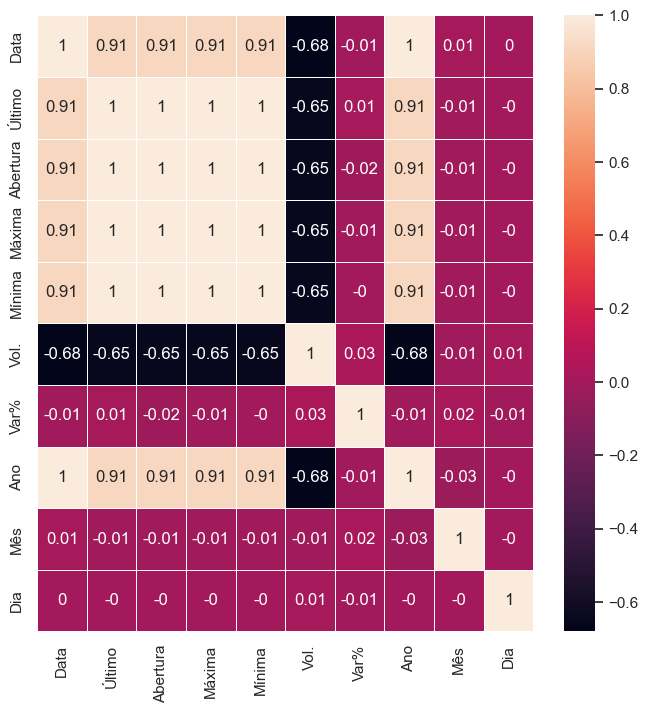

In [110]:
correlation_matrix = df[['Data','Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Ano', 'Mês', 'Dia']].corr().round(2)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, ax=ax)
plt.show()

# Criando Modelo de Regressão Linear Multipla

In [123]:
lr = LinearRegression()

In [128]:
X = df[['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Ano']]
y = df[['Último']]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [130]:
lr.fit(X_train, y_train)

LinearRegression()

In [131]:
y_pred = lr.predict(X_test)

In [133]:
r_sq = lr.score(X, y)

In [134]:
print('Coeficiente de Determinação (R²):', r_sq)

Coeficiente de Determinação (R²): 0.999837746008883


In [135]:
print('Intercepto:', lr.intercept_)

Intercepto: [0.69138177]


In [136]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coefficients

,0,0
0,Abertura,-5.453124e-01
1,Máxima,7.769580e-01
2,Mínima,7.685286e-01
3,Vol.,-1.548162e-11
4,Ano,-3.435752e-04


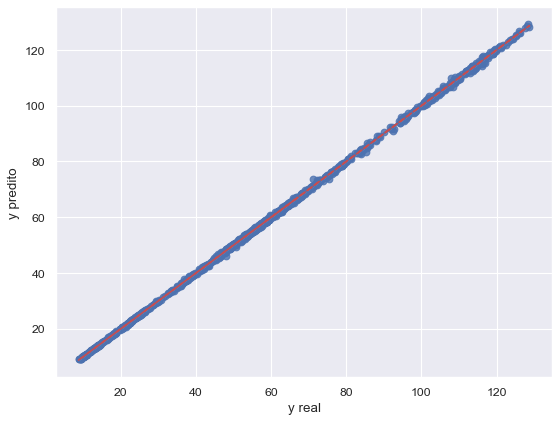

In [138]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams.update({'font.size': 14})
ax = sns.regplot(x = y_test, y = y_pred)
ax.set(xlabel='y real', ylabel='y predito')
ax = plt.plot(y_test, y_test, '--r')

plt.show()

In [142]:
# Avaliando o modelo
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE',MAE) # Mean Absolute Error (MAE) é a média do valor absoluto dos erros.
print('MSE',MSE) # Erro Quadrático Médio (MSE) é a média dos erros quadráticos
print('r²',r2) # (R-quadrado)

MAE 0.2715159042894933
MSE 0.14971725032417754
r² 0.9998437475804054
